**NB: Unfortunately, there was an update on Python version in the while. To guarantee the compatibility between Colab and the CausalGraphicModels, some modifications were made in the import part**

**Laboratory Lecture 8**

## Causal Inference in Python

An interesting and easy-to-use library to implement SCMs, including causal networks, is [CausalGraphicalModels](https://github.com/ijmbarr/causalgraphicalmodels). It can be installed in your Python environment as follows.

Let's start by introducing the [CausalGraphicalModels](https://github.com/ijmbarr/causalgraphicalmodels) by applying it to a variant of the Sprinkler example.

In [5]:
# NB Update 29/04/2023 to guarantee the compatibility

#!pip install causalgraphicalmodels
!sed -i 's/collections/collections.abc/g' /usr/local/lib/python3.10/dist-packages/causalgraphicalmodels/cgm.py
from causalgraphicalmodels import CausalGraphicalModel

sed: can't read /usr/local/lib/python3.10/dist-packages/causalgraphicalmodels/cgm.py: No such file or directory


ImportError: cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)

## SPRINKLER EXAMPLE

In [1]:
sprinkler = CausalGraphicalModel(
    nodes=["cloudy", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("cloudy", "rain"),
        ("cloudy", "sprinkler"),
        ("rain", "wet"),
        ("sprinkler", "wet"),
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

NameError: name 'CausalGraphicalModel' is not defined

In [ ]:
# get the distribution implied by the graph
print(sprinkler.get_distribution())

P(cloudy)P(rain|cloudy)P(sprinkler|cloudy)P(wet|rain,sprinkler)P(slippery|wet)


This description of the causal graphical model has been the same as those of general Bayesian Networks.

To endow these structures with a notion of causality, we some assumptions about what happens when an **intervention** occurs.

For instance, imagine that we had the power the control the weather. If use it to make an intervention on the "rain" node of our sprinkler model, we get the following system.

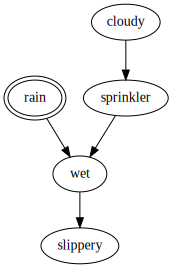

In [ ]:
sprinkler_do = sprinkler.do("rain")

sprinkler_do.draw()

The visualization has been changed.
A node with a **double outline** indicates a node with an intervention.

In [ ]:
print(sprinkler_do.get_distribution())

P(cloudy)P(sprinkler|cloudy)P(wet|do(rain),sprinkler)P(slippery|wet)


Obviously, the joint probability distribution is changed too.

##EXAMPLE: SIMPLE CONFOUNDED

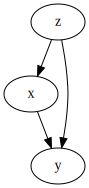

In [ ]:
from causalgraphicalmodels.examples import simple_confounded

simple_confounded.draw()

Under intervention on  X , the causal graphical model generating the data is

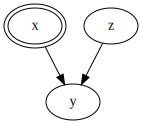

In [ ]:
simple_confounded.do("x").draw()

## EXAMPLE: BACKDOOR PATH

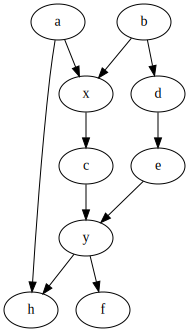

In [ ]:
from causalgraphicalmodels.examples import big_csm

example_cgm = big_csm.cgm
example_cgm.draw()

In [ ]:
example_cgm.get_all_backdoor_paths("x", "y")

[['x', 'a', 'h', 'y'], ['x', 'b', 'd', 'e', 'y']]

There are two backdoor paths between $X$ and $Y$

But because $h$ acts as a collider in the first path, it is blocked unless conditioned on. To find a valid adjustment set, we need a set which blocks this path. Any of the variables $B, D, E$ would work, as well as any combination of the above. We can also include any other variable in this set, as long as it doesn't create new paths. Adding $H, F$ or $C$ to the adjustment set would create a new path, making the adjustment set invalid.

In [ ]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"a", "h"})

False

In [ ]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e"})

True

In [ ]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e", "h"})

False

In [ ]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e", "f"})

False

In [ ]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"a","b"})

True

We can compute all valid adjustment sets using the following:

In [ ]:
example_cgm.get_all_backdoor_adjustment_sets("x", "y")

frozenset({frozenset({'e'}),
           frozenset({'d'}),
           frozenset({'a', 'd'}),
           frozenset({'b'}),
           frozenset({'a', 'e'}),
           frozenset({'a', 'b', 'e'}),
           frozenset({'a', 'd', 'e'}),
           frozenset({'a', 'b'}),
           frozenset({'b', 'd'}),
           frozenset({'d', 'e'}),
           frozenset({'b', 'e'}),
           frozenset({'b', 'd', 'e'}),
           frozenset({'a', 'b', 'd'}),
           frozenset({'a', 'b', 'd', 'e'})})

## EXAMPLE: front-door criterion

Finally, let's consider the smoking example, where we have one or more unobserved confounders, for example $U$ (smoking gene), and one or more observed variables, for example $Z$ (tar deposit), between cause $X$ (smoking) and outcome $Y$ (lung cancer):

<img src='https://drive.google.com/uc?id=1emjrUC_sUyiWxZEqRyxnEetDal6XjyGB'>

In this case, a possible implementation of the network is the following:

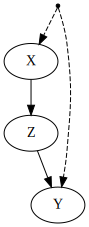

In [ ]:
bdnet3 = CausalGraphicalModel(
    nodes = ['X', 'Y', 'Z'],
    edges = [
        ('X','Z'),
        ('Z', 'Y')
    ],
    latent_edges = [
    ('X', 'Y')
    ]

)

bdnet3.draw()

where the variable  U , since unobserved, is substituted by a generic confounder link (dashed arrows) between  X  and  Y . The following method can be used to detect all the valid sets for applying the front-door criterion:

In [ ]:
bdnet3.get_all_frontdoor_adjustment_sets('X', 'Y')

frozenset({frozenset({'Z'})})

The answer is indeed the intermediate variable  Z.